In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sys

# for plots
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

from energy_datasets.spain_energy_weather import sp_energy_loader as sp


In [3]:
class MainConfig:
    context_length = 12
    lags_sequence = [1, 2, 3, 4, 5, 6, 7]
    prediction_length = 14
    wandb = False
    train_batch_size = 8
    valid_batch_size = 16
    lr = 5e-3
    epochs = 20#50
    device = "cuda" if torch.cuda.is_available() else "cpu" # Sometimes there's an issue with trying to use gpu



In [4]:
"""Extracting data"""
df = sp.get_raw_dataframe()
df = sp.proc_dataframe_dates(df)
df[:30]


,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,year,week,hour
0,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41,0.995553,0.019231,0
1,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92,0.995553,0.019231,1
2,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48,0.995553,0.019231,2
3,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32,0.995553,0.019231,3
4,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04,0.995553,0.019231,4
5,410.0,178.0,4038.0,3590.0,156.0,2109.0,952.0,743.0,7098.0,43.0,...,4618.0,4.0,4617.0,21441.0,19905.0,35.72,53.63,0.995553,0.019231,5
6,401.0,172.0,4040.0,3368.0,158.0,2108.0,961.0,848.0,7098.0,43.0,...,4397.0,3.0,4276.0,21285.0,20010.0,35.13,51.73,0.995553,0.019231,6
7,408.0,172.0,4030.0,3208.0,160.0,2031.0,983.0,1012.0,7099.0,43.0,...,3992.0,12.0,3994.0,21545.0,20377.0,36.22,51.43,0.995553,0.019231,7
8,413.0,177.0,4052.0,3335.0,161.0,2119.0,1001.0,1015.0,7098.0,43.0,...,3629.0,39.0,3602.0,21443.0,20094.0,32.40,48.98,0.995553,0.019231,8
9,419.0,177.0,4137.0,3437.0,163.0,2170.0,1041.0,1357.0,7097.0,43.0,...,3073.0,784.0,3212.0,21560.0,20637.0,36.60,54.20,0.995553,0.019231,9


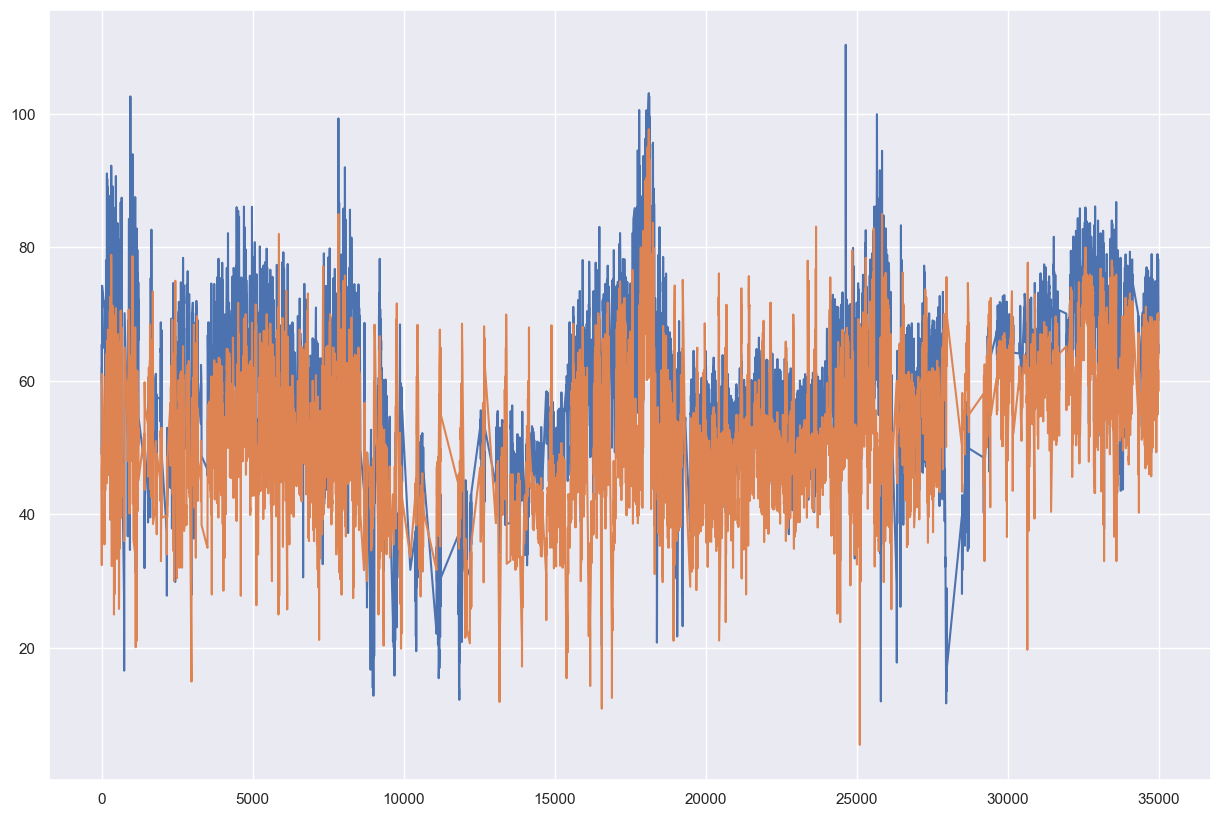

In [5]:
"""Check data"""
sns.set_theme()
plt.figure(figsize= (15, 10))
plt.plot(df['price actual'])
plt.plot(df['price day ahead'])
plt.show()

In [6]:
scale = MinMaxScaler(feature_range=(-1, 1)) # The normalizer
df_scaled = df.copy()

for c in df_scaled.columns:
    df_scaled[c] = scale.fit_transform(df_scaled[c].values.reshape(-1, 1))



df_scaled

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,year,week,hour
0,0.304556,-0.341365,-0.654360,0.078468,-0.696970,-0.609955,-0.04250,-0.618585,0.987207,-0.235294,...,-0.198434,-0.994372,-0.187282,-0.278718,-0.346483,-0.032314,0.088992,-1.0,-1.000000,-1.000000
1,0.314149,-0.343373,-0.598703,0.060793,-0.721212,-0.584163,-0.09500,-0.670665,0.987207,-0.235294,...,-0.262100,-0.994724,-0.263483,-0.389068,-0.437446,-0.075689,0.079059,-1.0,-1.000000,-0.913043
2,0.309353,-0.353414,-0.652305,0.014194,-0.727273,-0.473756,-0.14000,-0.732685,0.989034,-0.235294,...,-0.318069,-0.997538,-0.316298,-0.521320,-0.586904,-0.092388,0.070140,-1.0,-1.000000,-0.826087
3,0.261391,-0.491968,-0.738161,-0.106320,-0.709091,-0.320362,-0.17000,-0.860616,0.988425,-0.235294,...,-0.347162,-0.999648,-0.356106,-0.602684,-0.718224,-0.202125,-0.034462,-1.0,-1.000000,-0.739130
4,0.213429,-0.626506,-0.767254,-0.184253,-0.733333,-0.174208,-0.16500,-0.873366,0.987816,-0.235294,...,-0.386693,-0.997186,-0.394206,-0.682557,-0.810910,-0.285838,-0.100953,-1.0,-1.000000,-0.652174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34988,-0.318945,0.439759,0.026326,-0.427691,0.103030,-1.000000,0.10250,-0.349541,0.364606,0.098039,...,-0.228050,-0.990503,-0.236287,0.296612,0.311658,0.312514,0.255017,1.0,0.961538,0.739130
34989,-0.318945,0.353414,-0.151553,-0.438939,0.103030,-1.000000,0.08875,-0.483306,0.365215,0.117647,...,-0.187606,-0.993317,-0.197136,0.248800,0.267492,0.227716,0.166025,1.0,0.961538,0.826087
34990,-0.395683,0.140562,-0.333860,-0.443760,0.084848,-0.974661,0.12000,-0.652728,0.365215,0.098039,...,-0.134116,-0.994020,-0.184655,0.086537,0.110869,0.220776,0.131968,1.0,0.961538,0.913043
34991,-0.376499,-0.379518,-0.499723,-0.511248,0.066667,-0.916290,0.10125,-0.720800,0.365215,0.117647,...,-0.109198,-0.995076,-0.162189,-0.155599,-0.107967,0.148341,0.062031,1.0,0.961538,1.000000


In [7]:
scale.fit(df['price actual'].values.reshape(-1, 1))

MinMaxScaler(feature_range=(-1, 1))

In [8]:
def get_rolling_window(df:pd.DataFrame, context_length=None, predict_length=None, win_size=None, format='list'):#, return_dict=False):
    """Window Splitting"""
    if win_size is None:
        win_size = context_length + predict_length
    rolling_bins = df.rolling(window=(win_size), closed='left')

    if format=='dataframe':
        return [s for s in rolling_bins][win_size:]

    if format=='dict':
        return [s.to_dict(orient='list') for s in (rolling_bins)][win_size:]
    
    rolling_bins = [list(s.values) for s in (rolling_bins)][win_size:]

    return rolling_bins

In [9]:
train_size = int(0.8*len(df.index))
test_size = df.index-train_size

testing_df = df.iloc[:200]

dict_train = {
    "past_values":[], 
    "future_values":[], 
    "past_time_features":[], 
    "future_time_features":[], 
    'past_observed_mask':[]
}

dict_test = {
    "past_values":[], 
    "future_values":[], 
    "past_time_features":[], 
    "future_time_features":[],
    'past_observed_mask':[]
}

win_size=MainConfig.context_length + max(MainConfig.lags_sequence) + MainConfig.prediction_length
train_seg = MainConfig.context_length + max(MainConfig.lags_sequence)
pred_seg = MainConfig.prediction_length

df_rolling = get_rolling_window(df_scaled, win_size=win_size, format='dataframe')#return_dict=True)


for datapt in df_rolling[:train_size]:
    dict_train['past_values'].append(datapt['price actual'].iloc[:train_seg].values)
    dict_train['future_values'].append(datapt['price actual'].iloc[train_seg:train_seg+pred_seg].values)
    dict_train['future_time_features'].append(datapt.drop(['price actual'], axis=1).iloc[train_seg:train_seg+pred_seg].values)
    dict_train['past_observed_mask'].append([1]*(train_seg))
    dict_train['past_time_features'].append(datapt.drop(['price actual'], axis=1).iloc[:train_seg].values)

for datapt in df_rolling[train_size:]:
    dict_test['past_values'].append(datapt['price actual'].iloc[:train_seg].values)
    dict_test['future_values'].append(datapt['price actual'].iloc[train_seg:train_seg+pred_seg].values)
    dict_test['future_time_features'].append(datapt.drop(['price actual'], axis=1).iloc[train_seg:train_seg+pred_seg].values)
    dict_test['past_time_features'].append(datapt.drop(['price actual'], axis=1).iloc[:train_seg].values)
    dict_test['past_observed_mask'].append([1]*(train_seg))

In [10]:
"""
"past_values", 
"future_values",
"past_time_features",
"future_time_features"
"""
"""Dataset (dictionary)"""
from torch.utils.data import Dataset
class EnergyDataset(Dataset):
    def __init__(self, df:pd.DataFrame):
        self.len = len(df.index)
        self.dict_values = df.to_dict(orient='list')
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        return {
            k : torch.tensor(v[idx]).float().to('cpu') for k, v in self.dict_values.items() 
        }


In [34]:
eds_train = EnergyDataset(df=pd.DataFrame(dict_train))
eds_train[0]#['past_values'].shape

{'past_values': tensor([ 0.0890,  0.0791,  0.0701, -0.0345, -0.1010, -0.1498, -0.1883, -0.1944,
         -0.2441, -0.1383, -0.0422, -0.0235, -0.0182,  0.0209,  0.0211, -0.0255,
          0.0032,  0.0754,  0.2684]),
 'future_values': tensor([ 0.2680,  0.1976,  0.0785,  0.2120,  0.0758, -0.0162, -0.0787, -0.1435,
         -0.1539, -0.0880,  0.0501,  0.1030,  0.2226,  0.0639]),
 'past_time_features': tensor([[ 0.3046, -0.3414, -0.6544,  0.0785, -0.6970, -0.6100, -0.0425, -0.6186,
           0.9872, -0.2353, -0.2105, -0.9832, -0.3036, -0.1984, -0.9944, -0.1873,
          -0.2787, -0.3465, -0.0323, -1.0000, -1.0000, -1.0000],
         [ 0.3141, -0.3434, -0.5987,  0.0608, -0.7212, -0.5842, -0.0950, -0.6707,
           0.9872, -0.2353, -0.2632, -0.9828, -0.3117, -0.2621, -0.9947, -0.2635,
          -0.3891, -0.4374, -0.0757, -1.0000, -1.0000, -0.9130],
         [ 0.3094, -0.3534, -0.6523,  0.0142, -0.7273, -0.4738, -0.1400, -0.7327,
           0.9890, -0.2353, -0.2105, -0.9828, -0.3036, -0.31

In [12]:
"""model 2"""
from transformers import AutoformerConfig, AutoformerModel, AutoformerForPrediction, get_cosine_schedule_with_warmup

config = AutoformerConfig(
                          prediction_length=MainConfig.prediction_length, 
                          context_length=MainConfig.context_length,
                          lags_sequence=MainConfig.lags_sequence,
                          num_time_features=len(dict_test['future_time_features'][0][0]),                              
                          d_model=16,
                          encoder_layers=1,
                          decoder_layers=1,
                          encoder_ffn_dim=8,
                          decoder_ffn_dim=8,
                          distribution_output="student_t",
                          moving_average=15,
                          num_parallel_samples=1000,
                          dropout=0,
                          encoder_layerdrop=0,
                          decoder_layerdrop=0,
                          activation_dropout=0,
                          #return_dict=True
)
model = AutoformerForPrediction(config).to(MainConfig.device) # The model


In [13]:
config.num_time_features

22

In [14]:
from torch.optim import AdamW
from transformers import (
    get_cosine_schedule_with_warmup, 
    TrainingArguments,
    Trainer
)

"""Set up training params"""
optimizer = AdamW(model.parameters(), lr=MainConfig.lr)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=200, num_training_steps=int(len(eds_train)/MainConfig.train_batch_size)*MainConfig.epochs)

def model_init():
    return model


arguments = TrainingArguments(output_dir="tmp_trainer", 
                      learning_rate=MainConfig.lr, 
                      per_device_train_batch_size=MainConfig.train_batch_size, 
                      per_device_eval_batch_size=MainConfig.valid_batch_size, 
                      save_strategy="epoch",
                      num_train_epochs=MainConfig.epochs,
                      ignore_data_skip=True,
                      warmup_ratio=0.8,
                      label_smoothing_factor=0.0,
                      logging_strategy="epoch",
                      use_cpu=(MainConfig.device == "cpu"),
                      )

trainer = Trainer(model=model,
         train_dataset=eds_train, 
         args=arguments,
         optimizers=(optimizer, scheduler)
         )

In [15]:
trainer.train()

  5%|▌         | 1413/28020 [00:14<04:34, 97.04it/s] 

{'loss': -0.5653, 'grad_norm': 5.075726509094238, 'learning_rate': 0.004977009975878888, 'epoch': 1.0}


 10%|█         | 2819/28020 [00:28<04:12, 99.68it/s] 

{'loss': -0.7116, 'grad_norm': 4.861180305480957, 'learning_rate': 0.004892699107811921, 'epoch': 2.0}


 15%|█▌        | 4215/28020 [00:42<03:56, 100.70it/s]

{'loss': -0.7779, 'grad_norm': 7.634253978729248, 'learning_rate': 0.004748537826897049, 'epoch': 3.0}


 20%|██        | 5621/28020 [00:56<03:40, 101.50it/s]

{'loss': -0.829, 'grad_norm': 6.371160984039307, 'learning_rate': 0.004548132149516049, 'epoch': 4.0}


 25%|██▌       | 7016/28020 [01:09<03:30, 99.62it/s] 

{'loss': -0.8645, 'grad_norm': 7.290039539337158, 'learning_rate': 0.00429649497615823, 'epoch': 5.0}


 30%|███       | 8425/28020 [01:24<03:21, 97.27it/s] 

{'loss': -0.8999, 'grad_norm': 4.55606746673584, 'learning_rate': 0.003999920699906356, 'epoch': 6.0}


 35%|███▌      | 9821/28020 [01:40<03:02, 99.82it/s] 

{'loss': -0.9171, 'grad_norm': 7.952785015106201, 'learning_rate': 0.0036658277599681765, 'epoch': 7.0}


 40%|████      | 11217/28020 [01:54<02:46, 100.93it/s]

{'loss': -0.9458, 'grad_norm': 4.46184778213501, 'learning_rate': 0.0033025730785825103, 'epoch': 8.0}


 45%|████▌     | 12624/28020 [02:10<02:40, 95.84it/s] 

{'loss': -0.9792, 'grad_norm': 3.3714942932128906, 'learning_rate': 0.0029192430229314586, 'epoch': 9.0}


 50%|█████     | 14024/28020 [02:24<02:26, 95.44it/s] 

{'loss': -0.9984, 'grad_norm': 5.452575206756592, 'learning_rate': 0.0025254261208883435, 'epoch': 10.0}


 55%|█████▌    | 15421/28020 [02:38<02:12, 94.80it/s] 

{'loss': -1.0184, 'grad_norm': 6.68882417678833, 'learning_rate': 0.002130973215836191, 'epoch': 11.0}


 60%|██████    | 16824/28020 [02:52<01:54, 97.37it/s] 

{'loss': -1.0458, 'grad_norm': 6.6852922439575195, 'learning_rate': 0.0017457510599877425, 'epoch': 12.0}


 65%|██████▌   | 18229/28020 [03:06<01:34, 103.32it/s]

{'loss': -1.0692, 'grad_norm': 9.040487289428711, 'learning_rate': 0.0013793955097657373, 'epoch': 13.0}


 70%|███████   | 19627/28020 [03:19<01:21, 103.48it/s]

{'loss': -1.093, 'grad_norm': 6.995919704437256, 'learning_rate': 0.0010410704967561907, 'epoch': 14.0}


 75%|███████▌  | 21025/28020 [03:32<01:07, 102.88it/s]

{'loss': -1.113, 'grad_norm': 11.366402626037598, 'learning_rate': 0.0007392388032785691, 'epoch': 15.0}


 80%|████████  | 22422/28020 [03:47<01:06, 83.59it/s] 

{'loss': -1.1352, 'grad_norm': 11.201825141906738, 'learning_rate': 0.0004814503763388456, 'epoch': 16.0}


 85%|████████▌ | 23834/28020 [04:00<00:40, 102.68it/s]

{'loss': -1.1538, 'grad_norm': 7.30142879486084, 'learning_rate': 0.00027415347503043503, 'epoch': 17.0}


 90%|█████████ | 25231/28020 [04:14<00:29, 93.54it/s] 

{'loss': -1.1677, 'grad_norm': 10.325429916381836, 'learning_rate': 0.00012253337529751803, 'epoch': 18.0}


 95%|█████████▌| 26631/28020 [04:28<00:15, 90.68it/s] 

{'loss': -1.1762, 'grad_norm': 14.743313789367676, 'learning_rate': 3.0382666661873947e-05, 'epoch': 19.0}


100%|██████████| 28020/28020 [04:42<00:00, 99.08it/s] 

{'loss': -1.1819, 'grad_norm': 8.563061714172363, 'learning_rate': 6.385280394149984e-09, 'epoch': 20.0}
{'train_runtime': 282.8221, 'train_samples_per_second': 792.3, 'train_steps_per_second': 99.073, 'train_loss': -0.9821466765856419, 'epoch': 20.0}


TrainOutput(global_step=28020, training_loss=-0.9821466765856419, metrics={'train_runtime': 282.8221, 'train_samples_per_second': 792.3, 'train_steps_per_second': 99.073, 'total_flos': 182673153120.0, 'train_loss': -0.9821466765856419, 'epoch': 20.0})

In [16]:

model.eval()


AutoformerForPrediction(
  (model): AutoformerModel(
    (scaler): AutoformerMeanScaler()
    (encoder): AutoformerEncoder(
      (value_embedding): AutoformerValueEmbedding(
        (value_projection): Linear(in_features=31, out_features=16, bias=False)
      )
      (embed_positions): AutoformerSinusoidalPositionalEmbedding(26, 16)
      (layers): ModuleList(
        (0): AutoformerEncoderLayer(
          (self_attn): AutoformerAttention(
            (k_proj): Linear(in_features=16, out_features=16, bias=True)
            (v_proj): Linear(in_features=16, out_features=16, bias=True)
            (q_proj): Linear(in_features=16, out_features=16, bias=True)
            (out_proj): Linear(in_features=16, out_features=16, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=16, out_features=8, bias=True)
          (fc2): Linear(in_features=8, out_features

In [136]:
samples = dict_test
test_amount = 100
samples = {
            k : torch.tensor(v)[:test_amount].float().to('cpu') for k, v in dict_test.items() 
        }

samples['past_time_features'].shape, samples['future_time_features'].shape
# len(dict_test['past_values'][0])

(torch.Size([100, 19, 22]), torch.Size([100, 14, 22]))

In [86]:
samples['future_time_features'] = []
for sample in samples['past_time_features']:
    samples['future_time_features'].append(pd.DataFrame(sample).rolling(window=30,closed='left', min_periods=1).mean().values)

In [88]:
samples['future_time_features'][0].shape

(19, 22)

In [91]:
samples['future_time_features'] = []

In [ ]:
"""Initialize Chornos zero-shot forecaster to forecast covariates"""

import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",#small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)


/opt/homebrew/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [103]:
samples['past_time_features'][0].shape

torch.Size([19, 22])

In [151]:
"""Predict future values using chronos forecaster (more realistic setting, where we dont know future vals)"""
samples['future_time_features'] = []
for series_sampl in samples['past_time_features']:
    # context must be either a 1D tensor, a list of 1D tensors,
    # or a left-padded 2D tensor with batch as the first dimension
    # forecast shape: [num_series, num_samples, prediction_length]
    future_preds = pipeline.predict(
        context=torch.tensor(series_sampl).T,
        prediction_length=MainConfig.prediction_length,
        num_samples=1,
    )
    samples['future_time_features'].append(future_preds.squeeze().T)

samples['future_time_features'] = torch.tensor(np.array(samples['future_time_features']))

torch.Size([22, 19])


/var/folders/2t/dh69lmc920l_h8vbm87mpzcw0000gn/T/ipykernel_6579/964605505.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context=torch.tensor(series_sampl).T,


torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([22, 19])
torch.Size([14, 22])
torch.Size([2

In [ ]:
print(samples['future_time_features'][0].shape) # Verify shapes match future time feature data values

In [155]:
outputs = model.generate(
    past_values = samples["past_values"],
    past_time_features = samples["past_time_features"],
    past_observed_mask = samples["past_observed_mask"],
    future_time_features = samples["future_time_features"],
)

In [156]:
y_pred = (outputs.sequences.mean(dim=1))
y_acc = samples['future_values']
y_pred.shape, y_acc, y_pred

(torch.Size([100, 14]),
 tensor([[-0.2062, -0.2299, -0.2495,  ..., -0.1928, -0.1654, -0.0866],
         [-0.2299, -0.2495, -0.2131,  ..., -0.1654, -0.0866, -0.0099],
         [-0.2495, -0.2131, -0.1739,  ..., -0.0866, -0.0099, -0.0722],
         ...,
         [-0.0381, -0.0637, -0.0685,  ..., -0.0280, -0.0472, -0.0825],
         [-0.0637, -0.0685, -0.0438,  ..., -0.0472, -0.0825, -0.1078],
         [-0.0685, -0.0438,  0.0111,  ..., -0.0825, -0.1078, -0.0324]]),
 tensor([[-0.1133, -0.0903, -0.0702,  ..., -0.0342, -0.0176,  0.0265],
         [-0.1817, -0.1670, -0.1431,  ..., -0.1693, -0.1731, -0.1568],
         [-0.2351, -0.1859, -0.1456,  ..., -0.0940, -0.0650, -0.0277],
         ...,
         [ 0.0082,  0.0051,  0.0091,  ..., -0.1372, -0.0944, -0.0792],
         [-0.0673, -0.0748, -0.0799,  ..., -0.2129, -0.2430, -0.2580],
         [-0.1087, -0.1127, -0.1422,  ..., -0.1452, -0.1471, -0.1447]]))

In [157]:
predicted = pd.DataFrame(scale.inverse_transform(y_pred.cpu().detach().numpy()))
original = pd.DataFrame(scale.inverse_transform(y_acc))
dayahead_model_predicted = df['price day ahead'].iloc[train_size:train_size+test_amount]



In [158]:
# See predicted vs original values
print(predicted)
print(original)
# print(y_acc)

# Flatten predictions into predict_len chunks
pred_flattened = torch.tensor([])
for i in range(0, len(predicted.index), MainConfig.prediction_length):
    pred_flattened = torch.cat((pred_flattened, torch.tensor(predicted.iloc[i])))

predict_flattened = pd.DataFrame(pred_flattened)[:len(predicted.index)]

           0          1          2          3          4          5   \
0   55.433044  56.567413  57.555511  57.964493  58.457607  59.247593   
1   52.054497  52.783867  53.959385  55.178509  56.638931  57.334953   
2   49.421719  51.847290  53.839817  54.878124  54.788208  54.887825   
3   48.809269  48.507015  48.800831  48.907581  49.852161  51.277328   
4   51.874592  52.951813  52.677845  53.880211  54.770668  54.799023   
..        ...        ...        ...        ...        ...        ...   
95  66.174973  62.263355  61.549515  61.332859  59.911289  60.767860   
96  61.184673  61.442406  62.642925  63.965183  63.995644  62.322754   
97  61.425053  61.272465  61.468575  60.855865  59.454994  58.221870   
98  57.699814  57.327713  57.077530  56.823853  56.965065  54.451252   
99  55.656673  55.461819  54.004185  53.568260  50.018887  50.113300   

           6          7          8          9          10         11  \
0   59.401089  59.951782  60.325729  59.931534  59.569965  59.3

[Text(-20.0, 0, ''),
 Text(0.0, 0, ''),
 Text(20.0, 0, ''),
 Text(40.0, 0, ''),
 Text(60.0, 0, ''),
 Text(80.0, 0, ''),
 Text(100.0, 0, ''),
 Text(120.0, 0, '')]

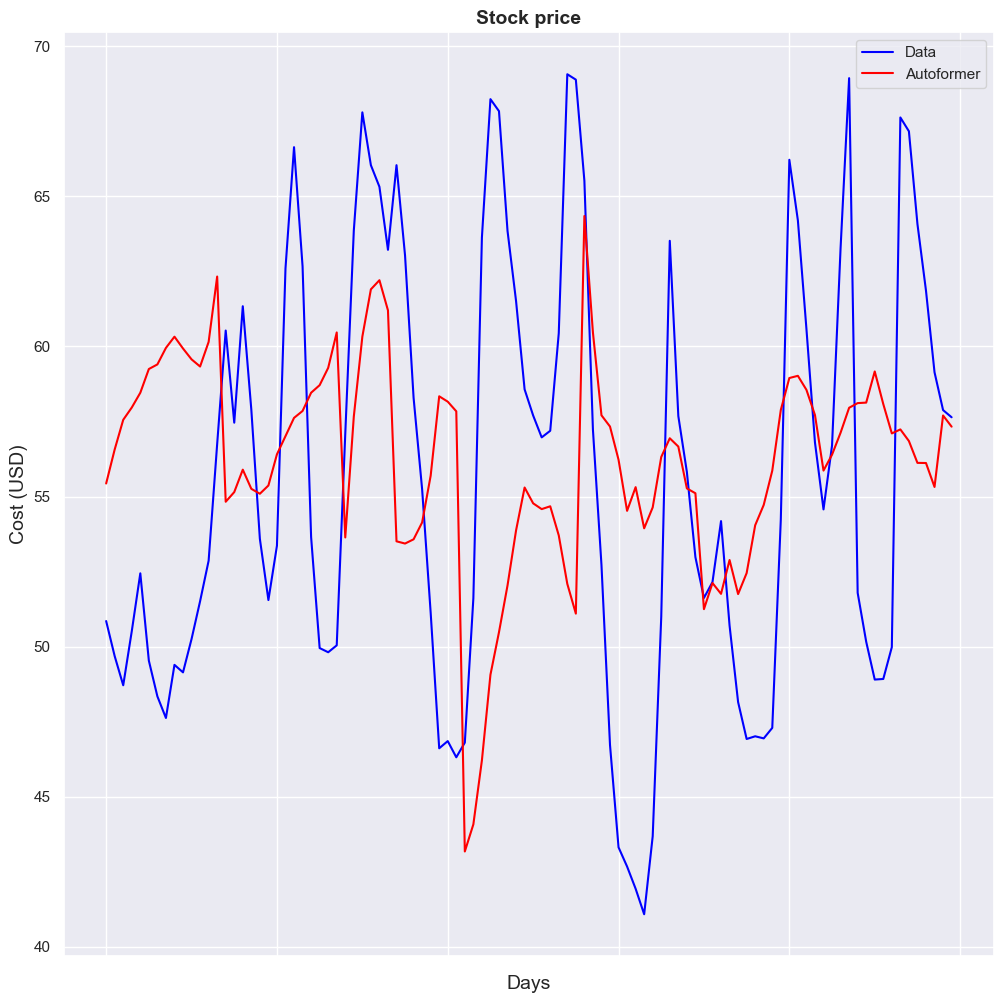

In [159]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predicted.index, y = predict_flattened.values.squeeze(), label="Autoformer", color='red')

ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


In [160]:
"""Checking MSE loss"""
criterion = nn.MSELoss()
criterion(torch.tensor([predicted.values]), torch.tensor([original.values])), criterion(torch.tensor([1.0]), torch.tensor([1.0]))

(tensor(83.2478, dtype=torch.float64), tensor(0.))

In [53]:
"""Saving and loading"""
# model.save_pretrained("saved_models/model2")
# model_loaded = AutoformerForPrediction.from_pretrained("saved_models/model2")